# Call-a-bike Data Analysis

Data Source: https://data.deutschebahn.com/dataset/data-call-a-bike

**Objective**

* Analyse call-a-bike booking data in Hamburg (55% of bookings in BOOKING csv file.)

In [1]:
import os.path
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename_HH = '../data/OPENDATA_BOOKING_CALL_A_BIKE_HH.csv'

start = time.time()
if os.path.isfile(filename_HH):
    df = pd.read_csv(filename_HH)
else:
    df = pd.read_csv('../data/OPENDATA_BOOKING_CALL_A_BIKE.csv', sep=';')
    df = df[df.CITY_RENTAL_ZONE == "Hamburg"]
    df.to_csv(filename_HH, index=False)
end = time.time()
print("took %.1f seconds" % (end-start))

took 44.3 seconds


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8942261 entries, 0 to 8942260
Data columns (total 17 columns):
BOOKING_HAL_ID               int64
CATEGORY_HAL_ID              int64
VEHICLE_HAL_ID               int64
CUSTOMER_HAL_ID              object
DATE_BOOKING                 object
DATE_FROM                    object
DATE_UNTIL                   object
COMPUTE_EXTRA_BOOKING_FEE    object
TRAVERSE_USE                 object
DISTANCE                     float64
START_RENTAL_ZONE            object
START_RENTAL_ZONE_HAL_ID     float64
END_RENTAL_ZONE              object
END_RENTAL_ZONE_HAL_ID       float64
RENTAL_ZONE_HAL_SRC          object
CITY_RENTAL_ZONE             object
TECHNICAL_INCOME_CHANNEL     object
dtypes: float64(3), int64(3), object(11)
memory usage: 1.1+ GB


In [4]:
df.nunique()

BOOKING_HAL_ID               8942261
CATEGORY_HAL_ID                    1
VEHICLE_HAL_ID                  2689
CUSTOMER_HAL_ID               270162
DATE_BOOKING                 8306518
DATE_FROM                    8306518
DATE_UNTIL                   8293164
COMPUTE_EXTRA_BOOKING_FEE          2
TRAVERSE_USE                       1
DISTANCE                           1
START_RENTAL_ZONE                216
START_RENTAL_ZONE_HAL_ID         323
END_RENTAL_ZONE                  216
END_RENTAL_ZONE_HAL_ID           218
RENTAL_ZONE_HAL_SRC                1
CITY_RENTAL_ZONE                   1
TECHNICAL_INCOME_CHANNEL         227
dtype: int64

In [5]:
df.head()

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
0,21366843,51000,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,2014-01-01 00:34:54,2014-01-01 00:50:14,Nein,Nein,0.0,U-Bahn Baumwall,214170.0,Mönckebergstraße / Rosenstraße,131880.0,Standort,Hamburg,iPhone SRH
1,21367069,51000,119830,1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2,2014-01-01 01:39:55,2014-01-01 01:39:55,2014-01-01 01:57:27,Nein,Nein,0.0,Bahnhof Altona Ost/Max-Brauer-Allee,131646.0,Schulterblatt/Eifflerstraße,131648.0,Standort,Hamburg,Android SRH
2,21367072,51000,143501,7AD2C1B70137479062A6DD73815835986677BB2D,2014-01-01 01:40:20,2014-01-01 01:40:20,2014-01-01 01:53:09,Nein,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Jarrestraße / Rambatzweg,138376.0,Standort,Hamburg,Techniker HH_119 (-2334-)
3,21367118,51000,117519,A1062EF019B4E3E71C551572F1B284D55440E3C4,2014-01-01 01:56:00,2014-01-01 01:56:00,2014-01-01 01:56:41,Nein,Nein,0.0,Große Bergstraße / Jessenstraße,131649.0,Große Bergstraße / Jessenstraße,131649.0,Standort,Hamburg,Terminal HH_46 (-2115-)
4,21367155,51000,108641,4F4F752203EA6FC872D576E9289C4E1B362E16F6,2014-01-01 02:05:55,2014-01-01 02:05:55,2014-01-01 02:13:49,Nein,Nein,0.0,Mundsburg / Schürbeker Straße,140799.0,Bartholomäusstraße/Beim Alten Schützenhof,211923.0,Standort,Hamburg,iPhone SRH


# Data Pre-processing

In [6]:
# parse date strings
for col in ['DATE_BOOKING', 'DATE_FROM', 'DATE_UNTIL']:
    df[col] = pd.to_datetime(df[col])

# add features
df['booking_date'] = df.DATE_BOOKING.dt.date
df['rented_minutes'] = np.floor((df.DATE_UNTIL - df.DATE_FROM).dt.seconds / 60).astype(int)

# Rental Time

* Per Booking:

In [7]:
print(pd.DataFrame(df.rented_minutes.describe().astype(int)))

       rented_minutes
count         8942261
mean               20
std                56
min                 0
25%                 7
50%                12
75%                20
max              1439


* Per User and Day:

In [8]:
s_user_daily_rented_minutes = (df.groupby(['CUSTOMER_HAL_ID', 'booking_date'])
                                 .rented_minutes.sum()
                                 .reset_index()
                                 .rented_minutes
                              )
print(pd.DataFrame(s_user_daily_rented_minutes.describe().astype(int)))

       rented_minutes
count         5354686
mean               34
std                89
min                 0
25%                 9
50%                17
75%                32
max             27626


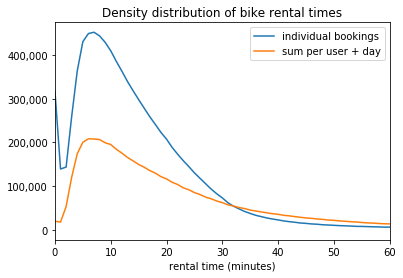

In [9]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
sns.lineplot(data=df.rented_minutes.value_counts(), label='individual bookings')
sns.lineplot(data=s_user_daily_rented_minutes.value_counts(), label='sum per user + day')
plt.xlabel('rental time (minutes)')
plt.title('Density distribution of bike rental times')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend()
plt.xlim(0, 60);

In [10]:
#df = df[(df.rented_minutes > 0) & (df.rented_minutes <= 120)]  # max 2h rentals

# Data Analysis

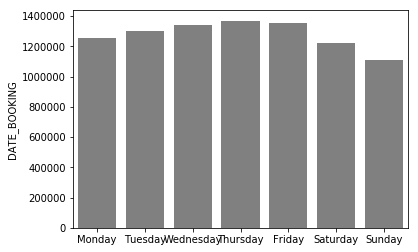

In [11]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekdays = df.DATE_BOOKING.dt.weekday_name.value_counts()
weekdays = weekdays.loc[day_order]
sns.barplot(x=weekdays.index, y=weekdays, color='grey');

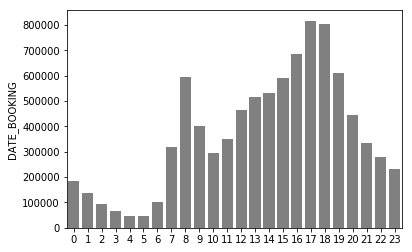

In [12]:
hour_of_day = df.DATE_BOOKING.dt.hour.value_counts()
sns.barplot(x=hour_of_day.index, y=hour_of_day, color='grey');

In [13]:
df_bookings = pd.DataFrame({'weekday': df.DATE_BOOKING.dt.weekday_name,
                            'hour_of_day': df.DATE_BOOKING.dt.hour}
                          )
df_weekday_hour = df_bookings.groupby(['weekday','hour_of_day']).size().reset_index()
df_weekday_hour = df_weekday_hour.set_index('weekday').loc[day_order].reset_index()
df_weekday_hour.columns = ['weekday','hour_of_day','count']

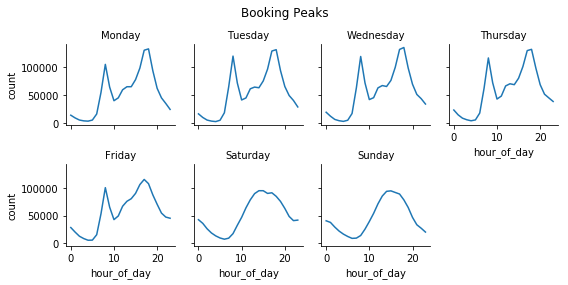

In [14]:
g = sns.FacetGrid(df_weekday_hour, col="weekday", col_wrap=4, height=2, aspect=1)
g = g.map(plt.plot, "hour_of_day", "count")
g.set_titles(col_template = '{col_name}')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Booking Peaks');

## Top Ride Origins

In [15]:
df.START_RENTAL_ZONE.value_counts().head()

Allende-Platz/Grindelhof         177195
Schulterblatt/Eifflerstraße      163699
Goldbekplatz / Semperstraße      130964
Jungfernstieg / Ballindamm       130025
Mundsburg / Schürbeker Straße    126885
Name: START_RENTAL_ZONE, dtype: int64

## Top Ride Destinations

In [16]:
df.END_RENTAL_ZONE.value_counts().head()

Allende-Platz/Grindelhof       178857
Schulterblatt/Eifflerstraße    163851
Jungfernstieg / Ballindamm     136375
Goldbekplatz / Semperstraße    132317
Landungsbrücke/Hafentor        131155
Name: END_RENTAL_ZONE, dtype: int64

## Top Ride Relations

In [17]:
relations = (
    df.groupby(['START_RENTAL_ZONE', 'END_RENTAL_ZONE'])
      .agg({'rented_minutes':['count','min','max','mean','median','std','var']})
      .reset_index().sort_values(('rented_minutes','count'), ascending=False)
)
relations.head(n=10)

START_RENTAL_ZONE                     END_RENTAL_ZONE  \
                                                                                
2800   Bahrenfelder Straße/Völckersstraße    Bahnhof Altona West / Busbahnhof   
2047     Bahnhof Altona West / Busbahnhof  Bahrenfelder Straße/Völckersstraße   
26882           Saarlandstraße/Wiesendamm      Schleidenstraße/Osterbekstraße   
0                Allende-Platz/Grindelhof            Allende-Platz/Grindelhof   
10704         Goldbekplatz / Semperstraße         Goldbekplatz / Semperstraße   
18372             Landungsbrücke/Hafentor             Landungsbrücke/Hafentor   
27119      Schleidenstraße/Osterbekstraße           Saarlandstraße/Wiesendamm   
6874      Eduard-Rhein-Ufer / Schwanenwik     Eduard-Rhein-Ufer / Schwanenwik   
27678         Schulterblatt/Eifflerstraße         Schulterblatt/Eifflerstraße   
30312                     U-Bahn Baumwall       Am Kaiserkai/Großer Grasbrook   

      rented_minutes                                                        
               count min   max       mean median         std           var  
2800           19852   0  1437   7.009319    4.0   38.390871   1473.859013  
2047           16055   0  1415   7.579259    4.0   31.871617   1015.799981  
26882          15731   0  1406   5.041892    3.0   32.302052   1043.422593  
0              15097   0  1430  21.058422    1.0   80.392253   6462.914313  
10704          14444   0  1433  32.644697    2.0   91.901608   8445.905600  
18372          13928   0  1438  57.608487    3.0  129.497302  16769.551237  
27119          13159   0  1423   5.008815    3.0   32.066541   1028.263032  
6874           12933   0  1434  27.820150    2.0   82.715755   6841.896201  
27678          12901   0  1431  24.859468    1.0   92.354623   8529.376451  
30312          12793   0  1093   6.708043    5.0   23.527306    553.534126

In [18]:
df_rel = df[df.START_RENTAL_ZONE == 'U-Bahn Baumwall']
df_rel = df[df.START_RENTAL_ZONE == 'Hallerstraße / Rohtenbaumchaussee']
df_rel = df[(df.START_RENTAL_ZONE == 'Bahrenfelder Straße/Völckersstraße') & (df.END_RENTAL_ZONE == 'Bahnhof Altona West / Busbahnhof')]
df_rel = df[(df.START_RENTAL_ZONE == 'Bahnhof Altona West / Busbahnhof') & (df.END_RENTAL_ZONE == 'Bahrenfelder Straße/Völckersstraße')]
df_rel = df[(df.START_RENTAL_ZONE == 'U-Bahn Baumwall') & (df.END_RENTAL_ZONE == 'Am Kaiserkai/Großer Grasbrook')]

In [19]:
df_rel_stats = pd.DataFrame({'weekday': df_rel.DATE_BOOKING.dt.weekday_name,
                            'hour_of_day': df_rel.DATE_BOOKING.dt.hour}
                          ).groupby(['weekday','hour_of_day']).size().reset_index()
df_rel_stats = df_rel_stats.set_index('weekday').loc[day_order].reset_index()
df_rel_stats.columns = ['weekday','hour_of_day','count']

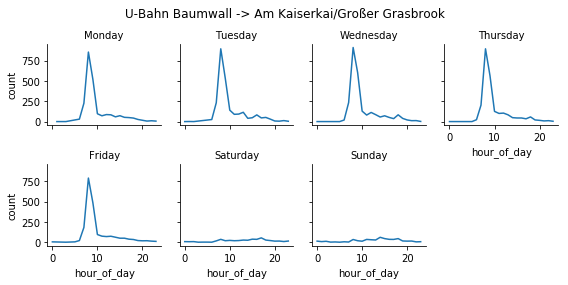

In [20]:
g = sns.FacetGrid(df_rel_stats, col="weekday", col_wrap=4, height=2, aspect=1)
g = g.map(plt.plot, "hour_of_day", "count")
g.set_titles(col_template = '{col_name}')
plt.subplots_adjust(top=0.85)
g.fig.suptitle(df_rel.START_RENTAL_ZONE.values[0] + ' -> ' + df_rel.END_RENTAL_ZONE.values[0]);

# User Analysis

In [21]:
top_users = df.CUSTOMER_HAL_ID.value_counts()
print(top_users.head())

496D35CFE3F625730E578793269E52D0A45FE53E    3132
7439201395BB2E80301974D4D00100F1F8A7AFB4    2799
6DF3E96544415EBFF474F968F264E144772F508E    2695
5EBBA60A2178EF837A2A2065E05B1A84C9B4FD94    2393
BDBE0F11FE2C06152C2D97FF4B02E02D1D962C6E    2263
Name: CUSTOMER_HAL_ID, dtype: int64


In [22]:
df[df.CUSTOMER_HAL_ID == top_users.index[0]].START_RENTAL_ZONE.value_counts().head()

Innocentiapark/Oberstraße         423
Allende-Platz/Grindelhof          395
Universität / Moorweidenstraße    361
Isestraße / Hoheluftbrücke        300
Heußweg/Wiesenstraße              282
Name: START_RENTAL_ZONE, dtype: int64

In [23]:
df[df.CUSTOMER_HAL_ID == top_users.index[0]].END_RENTAL_ZONE.value_counts().head()

Innocentiapark/Oberstraße         580
Universität / Moorweidenstraße    557
Allende-Platz/Grindelhof          277
Wartenau / Lübecker Straße        276
Zentralbibliothek / Münzstraße    200
Name: END_RENTAL_ZONE, dtype: int64

## For specific relation

In [24]:
top_users = df_rel.CUSTOMER_HAL_ID.value_counts()
print(top_users.head())

D87AD46A05C9E32541AE6DA8B4258B3ADBABEFD5    386
941942F01D6D806D7A2C019A8FE89AB11661CB6C    284
7F7D6B690A59D1C0CD4E28B4762093EC839635E0    256
BE0F4158F073A94873C7E179A08CFE3A4C9C4637    246
70A1F0558DBEE5BA6F382C8F6592E5D15B0721C6    228
Name: CUSTOMER_HAL_ID, dtype: int64


In [25]:
df[df.CUSTOMER_HAL_ID == top_users.index[0]].START_RENTAL_ZONE.value_counts().head()

Am Kaiserkai/Großer Grasbrook                  442
U-Bahn Baumwall                                406
Rödingsmarkt / Großer Burstah                   99
Auf dem Sande/Kehrwieder-MiniaturWunderland     19
Mönckebergstraße / Rosenstraße                  15
Name: START_RENTAL_ZONE, dtype: int64

In [26]:
df[df.CUSTOMER_HAL_ID == top_users.index[0]].END_RENTAL_ZONE.value_counts().head()

Am Kaiserkai/Großer Grasbrook     527
U-Bahn Baumwall                   204
Rödingsmarkt / Großer Burstah     179
Mönckebergstraße / Rosenstraße     33
Schulterblatt/Eifflerstraße        24
Name: END_RENTAL_ZONE, dtype: int64

## Popular ZONES

In [27]:
df.START_RENTAL_ZONE.value_counts().reset_index()
df_origin_freq = df.START_RENTAL_ZONE.value_counts().reset_index()
df_origin_freq.columns = ['RENTAL_ZONE','start']
df_dest_freq = df.END_RENTAL_ZONE.value_counts().reset_index()
df_dest_freq.columns = ['RENTAL_ZONE','end']

df_merged = pd.merge(df_origin_freq, df_dest_freq, on='RENTAL_ZONE')
df_merged['diff'] = df_merged.end - df_merged.start

### High Bike Demand (Hubs)

In [28]:
df_merged.sort_values('diff').head()

,RENTAL_ZONE,start,end,diff
13,Hauptbahnhof West / Glockengießer Wall,112500,97210,-15290
11,Hauptbahnhof Ost / Hachmannplatz,115785,103199,-12586
36,Bahnhof Altona West / Busbahnhof,82594,73789,-8805
27,Berliner Tor / Berlinertordamm,90159,83883,-6276
18,Bahnhof Altona Ost/Max-Brauer-Allee,100374,94238,-6136


### High Bike Supply (Sinks)

In [29]:
df_merged.sort_values('diff', ascending=False).head()

,RENTAL_ZONE,start,end,diff
8,Landungsbrücke/Hafentor,119522,131155,11633
23,Am Kaiserkai/Großer Grasbrook,91343,99942,8599
14,Jungfernstieg / Neuer Jungfernstieg,111242,119509,8267
105,Mannesallee/Veringstraße,32671,39630,6959
3,Jungfernstieg / Ballindamm,130025,136375,6350


### Balanced Demand and Supply

In [30]:
df_merged.sort_values('diff')[110:120]

,RENTAL_ZONE,start,end,diff
186,Gründgensstraße/César-Klein-Ring,3430,3430,0
214,BSC Testterminal Halle,23,23,0
47,Leinpfad/Fernsicht,73597,73603,6
174,Röntgenstraße/Philips,6645,6652,7
197,Neuländer Kamp/Eurofins,2347,2357,10
96,Steinstraße / Deichtorplatz,36275,36289,14
64,Lange Reihe / Kirchenallee,55607,55624,17
144,Versmannstraße/Am Hannoverschen Bahnhof,15499,15517,18
181,Friedrich-Ebert-Damm/Helbingtwiete,4162,4181,19
173,Hindenburgstraße/Möringbogen,6990,7015,25


## Investigate Many Days

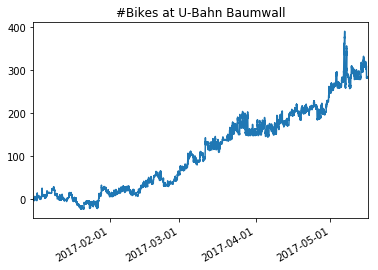

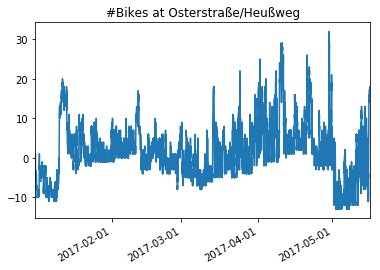

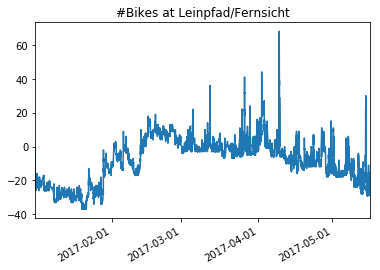

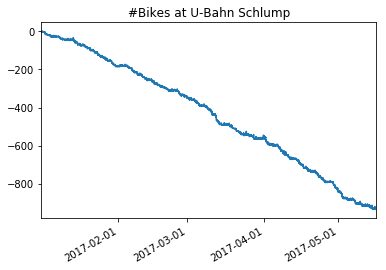

In [31]:
from datetime import date, datetime
from matplotlib.dates import MonthLocator

def plot_bike_trend(zone):
    df_origin = df[(df.START_RENTAL_ZONE == zone) & (df.DATE_BOOKING.dt.date >= date(2017, 1, 1))]
    df_dest   = df[(df.END_RENTAL_ZONE == zone) & (df.DATE_BOOKING.dt.date >= date(2017, 1, 1))]

    df_rental_times = (
        pd.concat([pd.DataFrame({'DATE_BOOKING':df_origin.DATE_BOOKING.values, 'bikes':-np.ones(len(df_origin))}),
                   pd.DataFrame({'DATE_BOOKING':df_dest.DATE_BOOKING.values, 'bikes':np.ones(len(df_dest))})]
        ).sort_values('DATE_BOOKING')
    )
    df_rental_times['sum'] = df_rental_times.bikes.cumsum()

    fig, ax = plt.subplots()
    pd.Series(index=df_rental_times.DATE_BOOKING.values, data=df_rental_times['sum'].values).plot();
    plt.title('#Bikes at ' + zone);
    ax.xaxis.set_major_locator(MonthLocator())

plot_bike_trend('U-Bahn Baumwall')
#plot_bike_trend('Landungsbrücke/Hafentor')
plot_bike_trend('Osterstraße/Heußweg')
plot_bike_trend('Leinpfad/Fernsicht')
plot_bike_trend('U-Bahn Schlump')
#plot_bike_trend('Hauptbahnhof West / Glockengießer Wall')

## Specific Origin

### Compare booked vs. returned bikes

In [32]:
#ZONE = 'U-Bahn Schlump'
ZONE = 'Osterstraße/Heußweg'
#ZONE = 'Hauptbahnhof West / Glockengießer Wall'
df_origin_freq = df[df.START_RENTAL_ZONE == ZONE].booking_date.value_counts().sort_index().reset_index()
df_origin_freq.columns = ['booking_date','start']
df_dest_freq = df[df.END_RENTAL_ZONE == ZONE].booking_date.value_counts().sort_index().reset_index()
df_dest_freq.columns = ['booking_date','end']

In [33]:
df_merged = pd.merge(df_origin_freq, df_dest_freq, on='booking_date')
df_merged['diff'] = df_merged.end - df_merged.start
df_merged.sort_values('diff').head()

,booking_date,start,end,diff
198,2017-04-30,107,87,-20
179,2017-04-11,90,71,-19
172,2017-04-04,84,68,-16
190,2017-04-22,56,42,-14
65,2016-12-18,39,26,-13


## Investigate single day

In [34]:
from datetime import date, datetime

my_date=pd.to_datetime('2016-03-12').date()
my_date=df_merged.sort_values('diff').booking_date.values[1]

df_origin = df[(df.START_RENTAL_ZONE == ZONE) & (df.booking_date == my_date)]
df_dest = df[(df.END_RENTAL_ZONE == ZONE) & (df.booking_date == my_date)]

In [35]:
s_lessbikes = pd.Series([-1-i for i in range(len(df_origin))], index=df_origin.DATE_BOOKING.sort_values())
s_morebikes = pd.Series([1+i for i in range(len(df_dest))], index=df_dest.DATE_BOOKING.sort_values())
s_cumsum = pd.concat([
    pd.Series(index=df_origin.DATE_BOOKING.values, data=-np.ones(len(df_origin))),
    pd.Series(index=df_dest.DATE_BOOKING.values, data=np.ones(len(df_dest)))
    ]).sort_index().cumsum()

/home/goerlitz/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


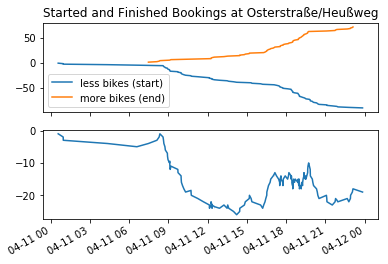

In [36]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
sns.lineplot(y=s_lessbikes.values, x=s_lessbikes.index, label='less bikes (start)', ax=ax1)
sns.lineplot(y=s_morebikes.values, x=s_morebikes.index, label='more bikes (end)', ax=ax1)
ax1.set_title('Started and Finished Bookings at ' + ZONE);
sns.lineplot(y=s_cumsum.values, x= s_cumsum.index, ax=ax2)
fig.autofmt_xdate()

# Bikes

In [37]:
# the most used bike and it's most frequent zones
top_bike = df.VEHICLE_HAL_ID.value_counts().index[0]

df[df.VEHICLE_HAL_ID == top_bike].START_RENTAL_ZONE.value_counts().head()

Allende-Platz/Grindelhof               152
Schulterblatt/Eifflerstraße            149
Sternschanze / Eingang Dänenweg        107
Lange Reihe / Lohmühlenpark            105
Jungfernstieg / Neuer Jungfernstieg    104
Name: START_RENTAL_ZONE, dtype: int64

# Bike Relocations

Goal: Identify gaps in bike itineraries which imply that a bike was relocated (transported by 'pickup' car) from one zone to another without a booking.

In [38]:
cols = ['VEHICLE_HAL_ID','DATE_BOOKING', 'START_RENTAL_ZONE', 'END_RENTAL_ZONE']

# find number of bike bookings which don't match previous END_RENTAL_ZONE.
df_itinerary = df[cols].sort_values(['VEHICLE_HAL_ID','DATE_BOOKING'])
df_itinerary['last_end'] = df_itinerary.groupby('VEHICLE_HAL_ID')['END_RENTAL_ZONE'].shift(1)
df_itinerary['gap'] = df_itinerary.last_end.notnull() & (df_itinerary.last_end != df_itinerary.START_RENTAL_ZONE)

In [39]:
df_bike_trips = df_itinerary.groupby('VEHICLE_HAL_ID').agg({'gap':['count','sum']})
df_bike_trips.columns = ['total', 'gap']

In [40]:
stats = df_bike_trips.sum().reset_index()
stats.columns = ['metric','value']
stats['percent'] = stats.value / sum(stats.value) * 100
stats

,metric,value,percent
0,total,8942261.0,98.041465
1,gap,178636.0,1.958535


In [41]:
df_itinerary.head()

,VEHICLE_HAL_ID,DATE_BOOKING,START_RENTAL_ZONE,END_RENTAL_ZONE,last_end,gap
7628219,106022,2016-10-27 15:22:32,Burgstraße/Hammer Landstraße,Hasselbrookstraße/Papenstraße,NaN,False
7630307,106022,2016-10-27 19:04:09,Lange Reihe / Kirchenallee,Eduard-Rhein-Ufer / Schwanenwik,Hasselbrookstraße/Papenstraße,True
7630785,106022,2016-10-27 19:24:41,Eduard-Rhein-Ufer / Schwanenwik,Bartholomäusstraße/Beim Alten Schützenhof,Eduard-Rhein-Ufer / Schwanenwik,False
7631470,106022,2016-10-27 20:57:31,Bartholomäusstraße/Beim Alten Schützenhof,Schleidenstraße/Osterbekstraße,Bartholomäusstraße/Beim Alten Schützenhof,False
7643762,106022,2016-10-29 15:18:30,Wiesendamm/Roggenkamp,Planetarium/Hindenburgstraße,Schleidenstraße/Osterbekstraße,True


## Top bike placement zones

In [42]:
df_itinerary[df_itinerary.gap].START_RENTAL_ZONE.value_counts().head()

Hauptbahnhof West / Glockengießer Wall    15379
Hauptbahnhof Ost / Hachmannplatz          13064
Bahnhof Altona West / Busbahnhof           8960
Berliner Tor / Berlinertordamm             6548
Bahnhof Altona Ost/Max-Brauer-Allee        6327
Name: START_RENTAL_ZONE, dtype: int64

## Top bike pick-up zones 

In [43]:
df_itinerary[df_itinerary.gap].last_end.value_counts().head()

Landungsbrücke/Hafentor                11933
Am Kaiserkai/Großer Grasbrook           9076
Jungfernstieg / Neuer Jungfernstieg     8569
Mannesallee/Veringstraße                6991
Jungfernstieg / Ballindamm              6817
Name: last_end, dtype: int64

## Top bike relocations

In [44]:
(df_itinerary[df_itinerary.gap]
 .groupby(['last_end', 'START_RENTAL_ZONE'])
 .size().reset_index()
 .sort_values(0, ascending=False)
).head()

,last_end,START_RENTAL_ZONE,0
8790,Landungsbrücke/Hafentor,Bahnhof Altona West / Busbahnhof,1122
10049,Mannesallee/Veringstraße,Hauptbahnhof West / Glockengießer Wall,1015
582,Am Kaiserkai/Großer Grasbrook,Hauptbahnhof West / Glockengießer Wall,982
8854,Landungsbrücke/Hafentor,Hauptbahnhof West / Glockengießer Wall,854
8789,Landungsbrücke/Hafentor,Bahnhof Altona Ost/Max-Brauer-Allee,832


## Booking Devices

In [45]:
df_device = df.TECHNICAL_INCOME_CHANNEL.value_counts().reset_index()
df_device.columns = ['TECHNICAL_INCOME_CHANNEL', 'count']
df_device['percent'] = df_device['count'] / sum(df_device['count'].values) * 100
df_device.head(n=10)

,TECHNICAL_INCOME_CHANNEL,count,percent
0,iPhone SRH,2285619,25.907600
1,Android SRH,1643372,18.627700
2,IVR,898882,10.188870
3,iPhone CAB,246892,2.798533
4,Android CAB,96776,1.096961
5,terminal HH_93 (-2215-),74501,0.844472
6,Terminal HH_5 (-2132-),58807,0.666580
7,Terminal HH_79 (-2323-),55124,0.624833
8,Terminal HH_34 (-2541-),53205,0.603081
9,Terminal HH_75 (-2364-),52295,0.592766
